# convnet study visulation

딥러닝 모델의 블랙박스는 옛말
컨브넷의 표현은 시각적인 개념 학습 -> 시각화하기 아주 좋음
1. 컨브넷 중간 층의 출력 시각화
    - 연속된 컨브넷 층이 입력을 어떻게 변형시키는지 이해하고 개별적인 컨브넷 필터의 의미를 파악하는 데 도움이 됨
2. 컨브넷 필터 시각화
    - 컨브넷의 필터가 찾으려는 시각적인 패턴과 개념이 무엇인지 상세하게 이해하는 데 도움이 됨
3. 클래스 활성화에 대한 히트맵을 이미지에 시각화

## 중간층의 출력 시각화(activation)

* 어떤 입력이 주어졌을 때 네트워크에 있는 여러 convolution과 pooling layer가 출력하는 feature map을 그림
* 네트워크에 의해 학습된 filter들이 어떨게 입력을 분해하는 지 보여줌
* width,height,ch의 세 개 차원에 대해 특성 맵을 시각화하는 것이 좋음

In [22]:
from keras.models import load_model

# input shape: (150,150,3)
model = load_model('cats_and_dogs_small_2.h5')
model.summary()  # 기억을 되살리기 위해서 모델 구조를 출력합니다

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)      

model에서 train 하지 않은 image를 통해 layer 활성화 과정을 따라가 보기

In [79]:
img_path = './datasets/cats_and_dogs_small/test/cats/cat.1700.jpg'

# 이미지를 4D 텐서로 변경합니다
from keras.preprocessing import image
import numpy as np

# 위 image 1개를 150x150 pixel로 load
img = image.load_img(img_path, target_size=(150, 150)) 

img_tensor = image.img_to_array(img) # 3D tensor 

In [80]:
img_tensor.shape

(150, 150, 3)

In [81]:
img_tensor = np.expand_dims(img_tensor, axis=0) # 4D로 변경, np
# 모델이 훈련될 때 입력에 적용한 전처리 방식을 동일하게 사용합니다
# color값을 [0,1] normalization
img_tensor /= 255.

# 이미지 텐서의 크기는(1, 150, 150, 3)입니다
print(img_tensor.shape)

(1, 150, 150, 3)


In [82]:
img_tensor.shape

(1, 150, 150, 3)

In [25]:
img_tensor=img_tensor[np.newaxis,:]
print(img_tensor.shape)

(1, 150, 150, 3)


>np.newaxis   
>
```
# make it as row vector by inserting an axis along first dimension
In [9]: row_vec = arr[np.newaxis, :]
In [10]: row_vec.shape
Out[10]: (1, 4)

# make it as column vector by inserting an axis along second dimension
In [11]: col_vec = arr[:, np.newaxis]
In [12]: col_vec.shape
Out[12]: (4, 1)
```

입력데이터의 첫번째 차원은 배치 차원입니다. 데이터가 하나뿐이더라도, 입력 데이터의 차원을 맞춰야 하므로 첫번째 차원을 추가합니다
->NONE으로 줘도 됨

In [83]:
import matplotlib.pyplot as plt

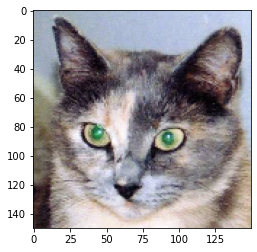

In [84]:
plt.imshow(img_tensor[0])
plt.show()

------------

**feature map을 추출하기 위해 image batch를 입력으로 받아 모든 convolution과 pooling 층의 활성화를 출력하는 케라스 모델 생성**

* 케라스의 models class 사용
* model instance를 만들 때 두개의 매개변수 필요 , 입력 텐서와 출력텐서
* 반환되는 객체는 Sequential과 같은 케라스 모델이지만 특정 입력과 특정 출력을 매핑하는 것과 차이가 있음
* Model 클래스를 사용하면 Sequential과는 달리 여러 개의 출력을 가진 모델을 만들 수 있다

In [31]:
from keras import models

# 상위 8개 층의 출력을 추출합니다:
layer_outputs = [layer.output for layer in model.layers[:8]]

In [32]:
layer_outputs

[<KerasTensor: shape=(None, 148, 148, 32) dtype=float32 (created by layer 'conv2d_1')>,
 <KerasTensor: shape=(None, 74, 74, 32) dtype=float32 (created by layer 'max_pooling2d_1')>,
 <KerasTensor: shape=(None, 72, 72, 64) dtype=float32 (created by layer 'conv2d_2')>,
 <KerasTensor: shape=(None, 36, 36, 64) dtype=float32 (created by layer 'max_pooling2d_2')>,
 <KerasTensor: shape=(None, 34, 34, 128) dtype=float32 (created by layer 'conv2d_3')>,
 <KerasTensor: shape=(None, 17, 17, 128) dtype=float32 (created by layer 'max_pooling2d_3')>,
 <KerasTensor: shape=(None, 15, 15, 128) dtype=float32 (created by layer 'conv2d_4')>,
 <KerasTensor: shape=(None, 7, 7, 128) dtype=float32 (created by layer 'max_pooling2d_4')>]

In [33]:
# 입력에 대해 8개 층의 출력을 반환하는 모델을 만듭니다:
#다중출력 model
activation_model = models.Model(inputs=model.input, outputs=layer_outputs) # (150,150,1), output_feature_map list

**1개의 입력과 layer의 활성화 마다 하나씩 총 8개의 output을 가짐**

In [86]:
# 층의 활성화마다 하나씩 8개의 넘파이 배열로 이루어진 리스트를 반환합니다:
activations = activation_model.predict(img_tensor)

In [87]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


In [91]:
third_layer_activation = activations[7]
print(third_layer_activation.shape)

(1, 7, 7, 128)


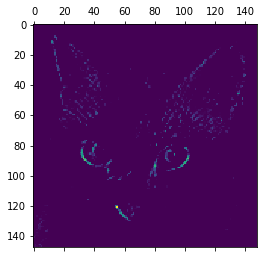

In [93]:
plt.matshow(first_layer_activation[0, :, :, 19], cmap='viridis')
plt.show()

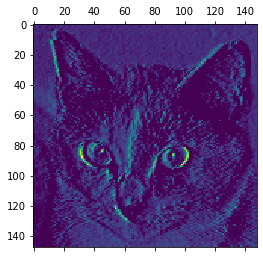

In [94]:
plt.matshow(first_layer_activation[0, :, :, 31], cmap='viridis')
plt.show()

**클리핑(Clipping)**: 임의의 실수인 층의 출력을 픽셀로 표현가능한 0~255로 바꾸어주는 것
* 먼저 평균을 빼고, 표준편차로 나눠 표준 점수로 바꿈
* 이루, 표준 점수 2.0 이내의 값(95%정도 포함)들이 0~255사이에 놓이도록 증폭 

<ipython-input-42-8c6ddef7f774>:30: RuntimeWarning: invalid value encountered in true_divide
  channel_image /= channel_image.std()


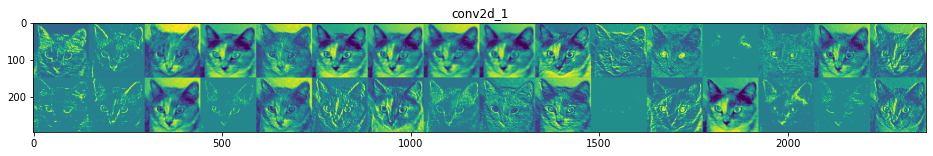

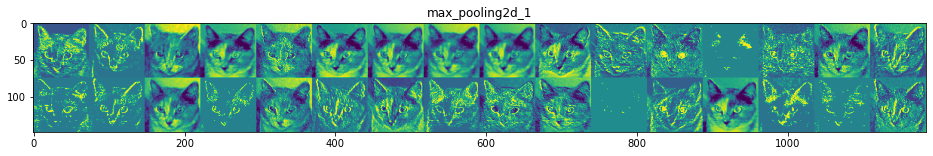

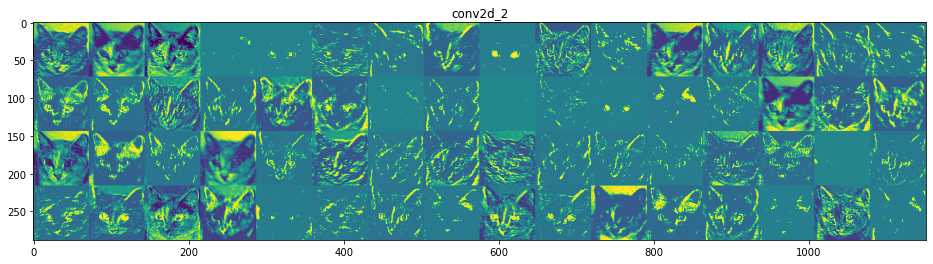

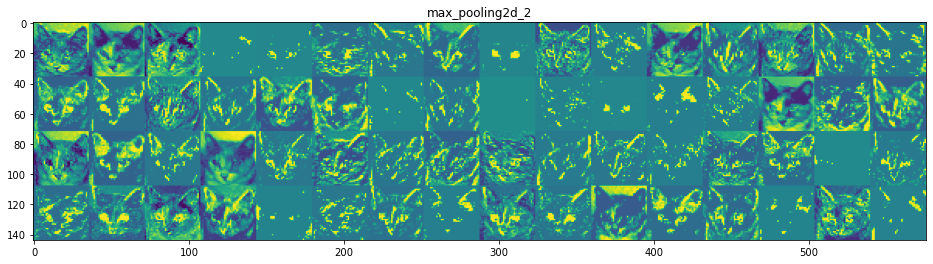

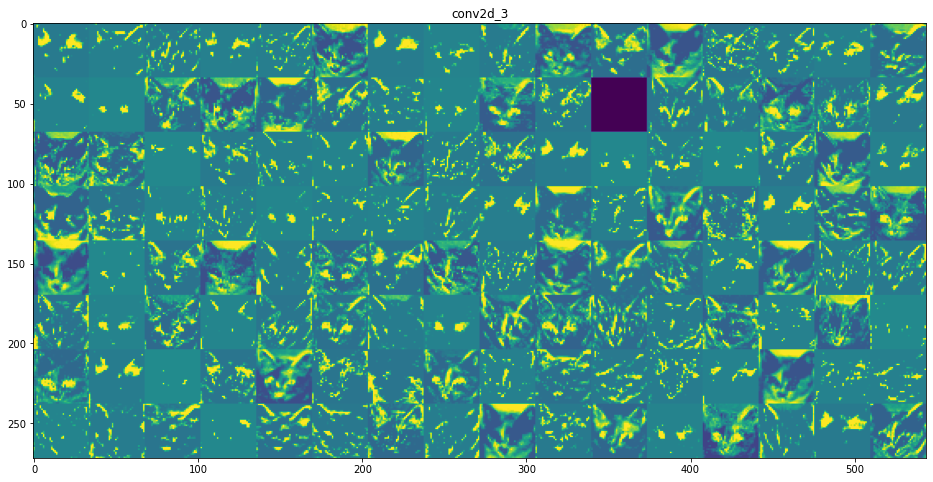

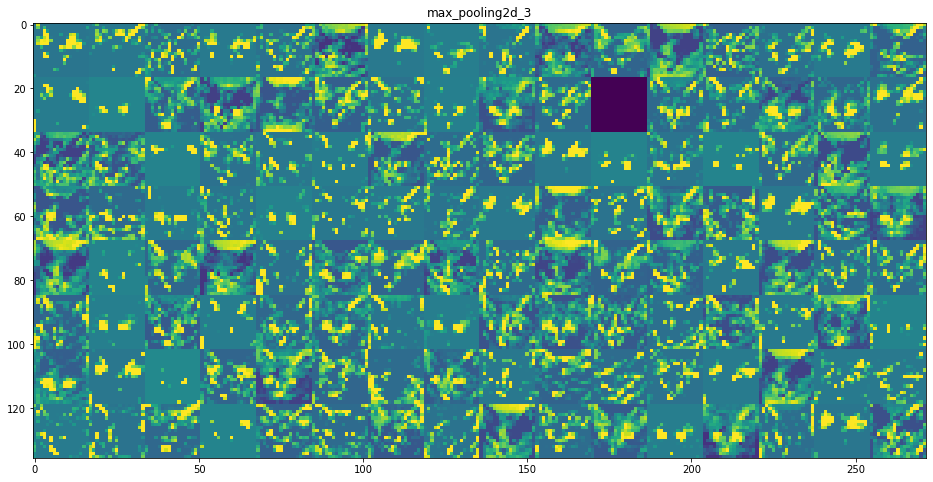

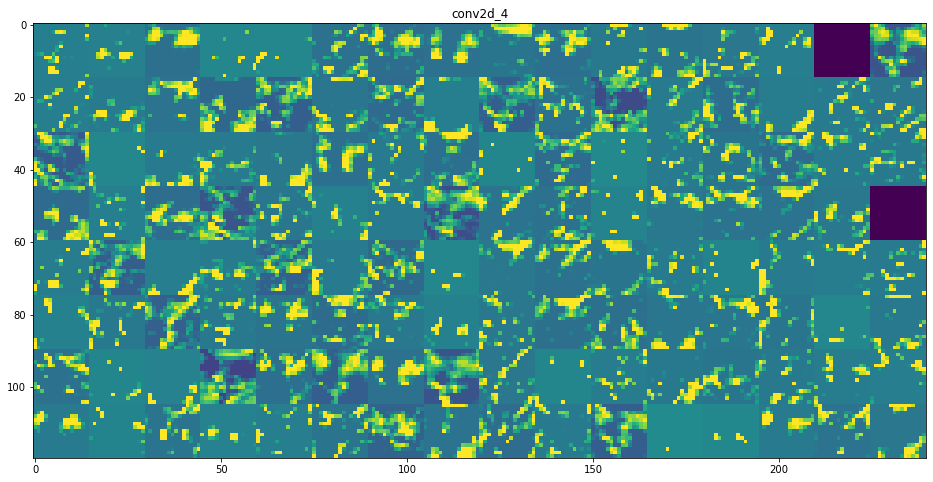

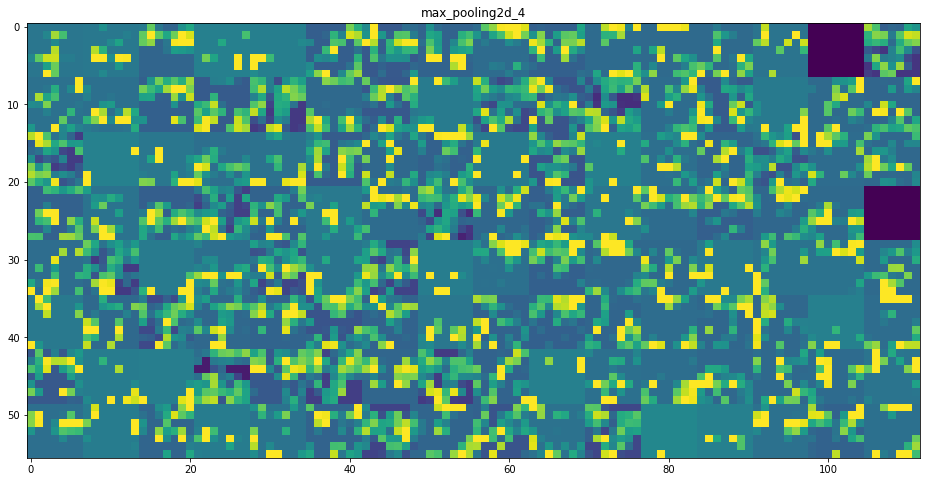

In [42]:
# 층의 이름을 그래프 제목으로 사용합니다
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

# ch별 feature map의 출력 plot의 가로길이가 16 gird
images_per_row = 16

# 특성 맵을 그립니다
for layer_name, layer_activation in zip(layer_names, activations):
    # feature map에 있는 feature(filter)의 수
    n_features = layer_activation.shape[-1]

    # feature map의 크기는 (1, size, size, n_features)입니다
    size = layer_activation.shape[1]

    # 활성화 채널을 위한 grid 크기를 구합니다
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # 각 활성화를 하나의 큰 그리드에 채웁니다
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # 그래프로 나타내기 좋게 특성을 처리합니다
            # 클리핑했다고 합니다
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # 그리드를 출력합니다
    # (patch size),ch수로 훌력
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show()

* 첫 번째 층은 여러 종류의 edge 감지기를 모아 놓은 것 같다.   
    이 단계의 활성화에는 초기 사진에 있는 거의 모든 정보가 유지된다   
    
* 상위 층으로 갈수록 활성화는 점점 더 추상적으로 되고 시각적으로 이해하기 어려워진다   
    '고양이 귀'와 '고양이 눈'과 같이 고수준의 개념을 인코딩하기 시작한다.   
    상위 층의 표현은 이미지의 시각적 콘텐츠에 관한 정보가 점점 줄어들고 이미지의 클래스에 관한 정보가 점점 증가한다
    
* 비어 있는 활성화가 층이 깊어짐에 따라 늘어난다.   
    첫 번째 층에서는 모든 필터가 입력 이미지에 활성화되었지만 층을 올라가면서 활성화되지 않는 필터들이 생긴다.    
    필터에 인코딩된 패턴이 입력 이미지에 나타나지 않았다는 것을 의미한다.

**심층 신경망은 입력되는 원본 데이터(여기서는 RGB 포맷의 사진)에 대한 정보 정제 파이프라인처럼 작동합니다.    
반복적인 변환을 통해 관계없는 정보(예를 들어 이미지에 있는 특정 요소)를 걸러내고 유용한 정보는 강조되고 개선됩니다(여기에서는 이미지의 class)**
-> pixel수가 적어지면서 정보가 모임

------------------

# Convnet filter 시각화

* 각 필터가 반응하는 시각적 패턴을 그려보아 filter를 조사할수 있다

빈 입력 이미지에서 시작해서 특정 필터의 응답을 최대화하기 위해 컨브넷 입력 이미지에 **경사 상승법**을 적용   
결과적으로 입력 이미지는 선택된 필터가 최대로 응답하는 이미지가 될 것   

>최소값을 찾는 것을 경사 하강법(gradient descent method), 최대값을 찾는 것을 경사 상승법(gradient ascent method)라고 한다.
>
>다만 손실 함수의 부호를 반전시키면 최소값을 찾는 문제와 최대값을 찾는 문제는 같은 것이니 하강이냐 상승이냐는 본질적으로는 중요하지 않다.


1. 특정 convolution layer의 한 filter 값을 최대화하는 손실 함수 정의
2. 이 활성화 값을 최대화하기 위해 입력 image를 변경하도록 확률적 경사상승법 사용 -> edge

In [75]:
from keras.applications import VGG16
from keras import backend as K

model = VGG16(weights='imagenet',
              include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output

In [49]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

경사 상승법을 구현하기 위해 모델의 입력에 대한 손실의 그래디언트가 필요함. 이를 위해 케라스의 backend 모듈에 있는 gradients 함수를 사용:

In [75]:
# 1.특정 convolution layer의 한 filter 값을 최대화하는 손실 함수 정의 - scalar
loss = K.mean(layer_output[:, :, :, filter_index])

In [62]:
# 2. 이 활성화 값을 최대화하기 위해 입력 image를 변경하도록 확률적 경사상승법 사용
# gradients 함수가 반환하는 텐서 리스트(여기에서는 크기가 1인 리스트)에서 첫 번째 텐서를 추출합니다
grads = K.gradients(loss, model.input)[0] # loss: filter 1개의 출력값을 average한 것이자 미분대상인 분자, input값: loss와 연관된 값들  ----> 미분값 출력

RuntimeError: tf.gradients is not supported when eager execution is enabled. Use tf.GradientTape instead.


### gradient Clipping

**경사 상승법 과정을 부드럽게 하기 위해 사용하는 한 가지 기법은 Gradient tensor를 L2 norm(텐서에 있는 값을 제곱합의 제곱근)으로 나누어 정규화하는 것입니다**
* graident tensor가 l2 norm일 때 l2 norm으로 나누면 1이 된다
* keras.optimizers 모듈을 통해서는 'clipnorm','clipvalue'를 통해서 자동으로 gradient cliiping을 수행할 수 있다

In [63]:
# 0 나눗셈을 방지하기 위해 1e–5을 더합니다
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

NameError: name 'grads' is not defined

입력 이미지에 대해 손실 텐서와 그래디언트 텐서를 계산해야 합니다.   
iterate는 넘파이 텐서(크기가 1인 텐서의 리스트)를 입력으로 받아 손실과 그래디언트 두 개의 넘파이 텐서를 반환합니다.

In [64]:
iterate = K.function([model.input], [loss, grads])

# 테스트:
import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

NameError: name 'grads' is not defined

>NOTE   
>경사 상승법을 사용하기 때문에 keras.optimizer 모듈 내 optimizer는 사용할 수 없다 -> 직접 학습단계를 구현해야 함
>
>* keras.backend.function()은 입력값을 받아 지정된 출력 tensor들을 얻을 수 있는 keras.backend.function 객체를 만들 수 있음

In [ ]:
# 잡음이 섞인 회색 이미지로 시작합니다
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.

# 업데이트할 그래디언트의 크기
step = 1.
for i in range(40):   # 경사 상승법을 40회 실행합니다
    # 손실과 그래디언트를 계산합니다
    loss_value, grads_value = iterate([input_img_data])
    # 손실을 최대화하는 방향으로 입력 이미지를 수정합니다 -> edge와 함께 설명할 것
    input_img_data += grads_value * step

In [ ]:
input_img_data[0].shape

이 tensor 값은 [0,255] 사이의 정수가 아님   
출력 가능한 이미지로 변경하기 위해 img 후처리

In [ ]:
def deprocess_image(x):
    # 텐서의 평균이 0, 표준 편차가 0.1이 되도록 정규화합니다
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # [0, 1]로 클리핑합니다
    x += 0.5
    x = np.clip(x, 0, 1)

    # RGB 배열로 변환합니다
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [ ]:
def generate_pattern(layer_name, filter_index, size=150):
    # 주어진 층과 필터의 활성화를 최대화하기 위한 손실 함수를 정의합니다
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # 손실에 대한 입력 이미지의 그래디언트를 계산합니다
    grads = K.gradients(loss, model.input)[0]

    # 그래디언트 정규화
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # 입력 이미지에 대한 손실과 그래디언트를 반환합니다
    iterate = K.function([model.input], [loss, grads])
    
    # 잡음이 섞인 회색 이미지로 시작합니다
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # 경사 상승법을 40 단계((왜요?)) 실행합니다
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    
    # 출력 가능한 이미지로 변경하기 위한 img 후처리 
    return deprocess_image(img)

In [ ]:
plt.imshow(generate_pattern('block3_conv1', 0))
plt.show()


 각 층에서 처음 64개의 필터만 사용하겠습니다. 또 각 합성곱 블럭의 첫 번째 층만 살펴보겠습니다(block1_conv1, block2_conv1, block3_conv1, block4_conv1, block5_conv1). 여기서 얻은 출력을 64 × 64 필터 패턴의 8 × 8 그리드로 정렬합니다. 각 필터 패턴 사이에 검은 색 마진을 약간 둡니다

In [ ]:
for layer_name in ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1']:
    size = 64
    margin = 5 # ch별 grid를 나누기 위한 선

    # 결과를 담을 빈 (검은) 이미지
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3), dtype='uint8')

    for i in range(8):  # results 그리드의 행을 반복합니다
        for j in range(8):  # results 그리드의 열을 반복합니다
            # layer_name에 있는 i + (j * 8)번째 필터에 대한 패턴 생성합니다
            filter_img = generate_pattern(layer_name, i + (j * 8), size=size)

            # results 그리드의 (i, j) 번째 위치에 저장합니다
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

    # results 그리드를 그립니다
    plt.figure(figsize=(20, 20))
    plt.imshow(results)
    plt.show()

> 이 컨브넷 필터들은 모델의 상위 층으로 갈수록 점점 더 복잡해지고 개선됩니다.
>
>* block2_conv1의 필터는 에지나 색깔의 조합으로 만들어진 간단한 질감을 인코딩합니다.
>* 더 상위 층의 필터는 깃털, 눈, 나뭇잎 등과 같은 자연적인 이미지에서 찾을 수 있는 질감을 닮아가기 시작합니다. 

pixel size가 줄어들지 않음


---------------------

# 클래스 활성화의 히트맵 시각화하기

heatmap: 색을 통해 activation 출력

>### Class Ativation MAP 시각화(CAM)
>이 방법은 이미지의 어느 부분이 컨브넷의 최종 분류 결정에 기여하는지 이해하는 데 유용합니다

클래스 활성화 히트맵은 특정 출력 클래스에 대해 입력 이미지의 모든 위치에 대해 계산된 2D 점수 그리드입니다

####  Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization
1. 입력 이미지가 주어지면 합성곱 층에 있는 특성 맵의 출력을 추출합니다
2. 그 다음 특성 맵의 모든 채널의 출력에 채널에 대한 클래스의 그래디언트 평균을 곱합니다

 '입력 이미지가 각 채널을 활성화하는 정도'에 대한 공간적인 맵을 '클래스에 대한 각 채널의 중요도'로 가중치를 부여하여 '입력 이미지가 클래스를 활성화하는 정도'에 대한 공간적인 맵을 만드는 것입니다

In [65]:
from keras.applications.vgg16 import VGG16

K.clear_session()

# 이전 모든 예제에서는 최상단의 완전 연결 분류기를 제외했지만 여기서는 포함합니다
model = VGG16(weights='imagenet') #include_top=Ture

>warn   
>VGG16 model은 224 × 224 크기의 이미지에서 훈련되었고 keras.applications.vgg16.preprocess_input 함수에 있는 몇 가지 규칙에 따라 전처리 되었습니다

In [68]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

# 이미지 경로
img_path = './datasets/creative_commons_elephant.jpg'

# -> vgg16에 넣기 위해
# 224 × 224 크기의 파이썬 이미징 라이브러리(PIL) 객체로 반환됩니다 
img = image.load_img(img_path, target_size=(224, 224))

# (224, 224, 3) 크기의 넘파이 float32 배열
x = image.img_to_array(img)

# 차원을 추가하여 (1, 224, 224, 3) 크기의 배치로 배열을 변환합니다
x = np.expand_dims(x, axis=0)

# 데이터를 전처리합니다(채널별 컬러 정규화를 수행합니다)
x = preprocess_input(x)

ImageNet class = 1000

In [69]:
preds = model.predict(x) # layer 수만큼의 len(1000)을 가진 numpy list 반환
print('Predicted:', decode_predictions(preds, top=3)[0]) # ImageNet 데이터셋에 대한 예측결과에서 top매개변수만큼의 가장 활성화가 돼있는 최상위 벡터을 반환

Predicted: [('n02504458', 'African_elephant', 0.909421), ('n01871265', 'tusker', 0.086182885), ('n02504013', 'Indian_elephant', 0.0043545826)]


아프리카 코끼리: 90.9%
코끼리: 8.6%
인도 코끼리: 0.4%

In [70]:
np.argmax(preds[0])

386

In [71]:
# 예측 벡터의 '아프리카 코끼리' 항목
african_elephant_output = model.output[:, 386]

# VGG16의 마지막 합성곱 층인 block5_conv3 층의 특성 맵
last_conv_layer = model.get_layer('block5_conv3')

# block5_conv3의 특성 맵 출력에 대한 '아프리카 코끼리' 클래스의 그래디언트
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

# 특성 맵 채널별 그래디언트 평균 값이 담긴 (512,) 크기의 벡터
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# 샘플 이미지가 주어졌을 때 방금 전 정의한 pooled_grads와 block5_conv3의 특성 맵 출력을 구합니다
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

# 두 마리 코끼리가 있는 샘플 이미지를 주입하고 두 개의 넘파이 배열을 얻습니다
pooled_grads_value, conv_layer_output_value = iterate([x])

# "아프리카 코끼리" 클래스에 대한 "채널의 중요도"를 특성 맵 배열의 채널에 곱합니다
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# 만들어진 특성 맵에서 채널 축을 따라 평균한 값이 클래스 활성화의 히트맵입니다
heatmap = np.mean(conv_layer_output_value, axis=-1)

RuntimeError: tf.gradients is not supported when eager execution is enabled. Use tf.GradientTape instead.

In [72]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

NameError: name 'heatmap' is not defined

In [73]:
import cv2

# cv2 모듈을 사용해 원본 이미지를 로드합니다
img = cv2.imread(img_path)

# heatmap을 원본 이미지 크기에 맞게 변경합니다
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# heatmap을 RGB 포맷으로 변환합니다
heatmap = np.uint8(255 * heatmap)

# 히트맵으로 변환합니다
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET) #jet colormap : 초록 파랑 빨강ㅇ

# 0.4는 히트맵의 강도입니다
superimposed_img = heatmap * 0.4 + img

# 디스크에 이미지를 저장합니다
cv2.imwrite('./datasets/elephant_cam.jpg', superimposed_img)

NameError: name 'heatmap' is not defined

1. 왜 network가 이 이미지에 아프리카 코끼리가 있다고 생각하는지
2. 아프리카 코끼리가 어디있는지
라는 질문의 답을 얻을 수 있다
-> 코끼리 새끼의 귀가 활성화되는 것을 보고 클래스 활성화가 이부분에서 중점적으로 일어나는 것을 알 수 있다